## Imports

In [354]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

## Setup dataframes etc

In [355]:
leg = ['Alcohol', 'Caff', 'Choc', 'Legalh',  'Nicotine']
ileg = ['Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',  'LSD', 'Meth', 'Mushrooms', 'VSA']
fic = ['Semer']

pers = ['neuroticism', 'extraversion', 'openness', 'agreeableness', 'conscientiousness', 'impulsive', 'sensation', 'intercept']
features = ['age', 'gender', 'education', 'country', 'ethnicity']


df = pd.read_csv('data/raw/data.csv', sep=',', index_col='id')
df.drop(features, axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

df2 = df.copy()

use_mapping = {'CL0': 0, #never used
               'CL1': 0, #over a decade ago
               'CL2': 0, #within the last decade
               'CL3': 0, #within the last year
               'CL4': 1, #within the last month
               'CL5': 1, #within the last week
               'CL6': 1} #within the last day

for j in ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms','Nicotine', 'Semer', 'VSA']:
    temp = []
    for i in df[j]:
        temp.append(use_mapping[i])

    df2[j] = temp


df2['any_illeg'] = 0
df2.loc[df2[ileg].sum(axis=1) > 0,'any_illeg'] = 1
df2['intercept'] = 1 #add intercept column for statsmodel

df2.shape


(1885, 28)

In [356]:
##Create a holdout test set for final results

idx = df2.sample(200, replace=False, random_state=42).index

holdout = df2.loc[idx]

df2.drop(idx, inplace=True)

holdout.shape, df2.shape

((200, 28), (1685, 28))

## Helper functions

In [357]:
def logistic(X):
    '''Given X, returns 1/(1+e^X)'''
    return 1/(1 + np.exp(X))

def predictor(clf, X, threshold):
    '''Given a model that predicts probabilities, returns 0-1 predictions with 0.5 threshold'''
    y_pred = clf.predict(X)
    return [0 if a < threshold else 1 for a in y_pred]

In [358]:
drug = 'any_illeg'
X = df2[pers]
y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [359]:
clf = sm.Logit(y_train, X_train).fit()

clf.summary()

Optimization terminated successfully.
         Current function value: 0.511738
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              any_illeg   No. Observations:                 1348
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            7
Date:                Sun, 31 Dec 2023   Pseudo R-squ.:                  0.2600
Time:                        16:05:55   Log-Likelihood:                -689.82
converged:                       True   LL-Null:                       -932.22
Covariance Type:            nonrobust   LLR p-value:                1.490e-100
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
neuroticism          -0.0896      0.080     -1.118      0.264      -0.247       0.068
extraversion         -0.3956      0.087     -4.539      0.000      -0.566      -0.225
openness              0.7899      0.082      9.618      0.000       0.629       0.951
agreeableness        -0.1523      0.072     -2.127      0.033      -0.293      -0.012
conscientiousness    -0.4393      0.081     -5.395      0.000      -0.599      -0.280
impulsive             0.1093      0.093      1.176      0.240      -0.073       0.292
sensation             0.8738      0.100      8.712      0.000       0.677       1.070
intercept             0.1648      0.066      2.490      0.013       0.035       0.295
=====================================================================================
"""

### Interpretation:

p-vals are interesting here, neuroticism and impulsiveness not significant, suggesting these traits are not useful in predicting drug use.

In [360]:
beta = np.array(clf.params).reshape(-1,1)
samp = np.array(X_train.iloc[244]).reshape(1,-1) #get a single samp for testing

logistic(samp@beta)[0][0], 1-clf.predict(samp)[0] #chance of belonging to the '0' class. This is just for my sanity check.

(0.943528876808991, 0.943528876808991)

Explaining Odds Ratios: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2938757/ 

Odds ratios are used to compare the relative odds of the occurrence of the outcome of interest (e.g. disease or disorder), given exposure to the variable of interest (e.g. health characteristic, aspect of medical history). The odds ratio can also be used to determine whether a particular exposure is a risk factor for a particular outcome, and to compare the magnitude of various risk factors for that outcome.

OR=1 Exposure does not affect odds of outcome

OR>1 Exposure associated with higher odds of outcome

OR<1 Exposure associated with lower odds of outcome

In [361]:
# code from https://www.andrewvillazon.com/logistic-regression-python-statsmodels/

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios#.to_latex()

,OR,Lower CI,Upper CI
neuroticism,0.914289,0.781341,1.069859
extraversion,0.673249,0.567512,0.798688
openness,2.203139,1.875596,2.587882
agreeableness,0.858734,0.746312,0.988092
conscientiousness,0.644501,0.549435,0.756016
impulsive,1.115542,0.929679,1.338564
sensation,2.396083,1.968449,2.916620
intercept,1.179148,1.035678,1.342492


We can interpret the odds ratios as for a 1 unit increase in neurotictism, the prob of taking any illicit drug decreases by 9% (100*(0.91 - 1))


In [362]:
y_pred = predictor(clf, X_test, 0.5)

f1_score(y_pred, y_test)

0.7445652173913043

In [363]:
drug_df = pd.DataFrame(index=pers[:-1])

Optimization terminated successfully.
         Current function value: 0.511738
         Iterations 6
Drug: any_illeg
F1 score: 0.745
                          OR  Lower CI  Upper CI     coefs  p_values
neuroticism        0.914289  0.781341  1.069859 -0.089608     0.264
extraversion       0.673249  0.567512  0.798688 -0.395639     0.000
openness           2.203139  1.875596  2.587882  0.789883     0.000
agreeableness      0.858734  0.746312  0.988092 -0.152296     0.033
conscientiousness  0.644501  0.549435  0.756016 -0.439279     0.000
impulsive          1.115542  0.929679  1.338564  0.109341     0.240
sensation          2.396083  1.968449  2.916620  0.873835     0.000
intercept          1.179148  1.035678  1.342492  0.164792     0.013


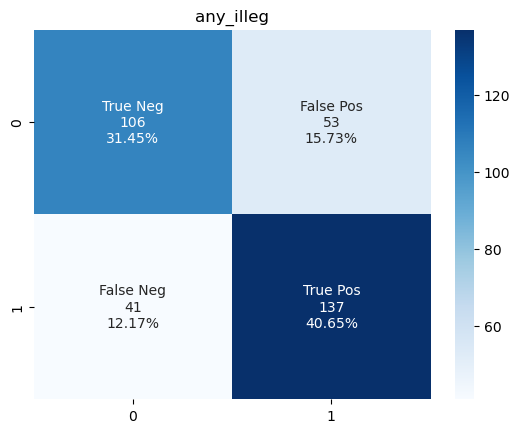

In [364]:
drug = 'any_illeg'

y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = sm.Logit(y_train, X_train).fit()

#print(clf.summary())

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios['coefs'] = clf.params
odds_ratios['p_values'] = clf.pvalues.round(3)



y_pred = predictor(clf, X_test, 0.5)
cm = confusion_matrix(y_test, y_pred)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_test):.3}\n {odds_ratios}')

_, axes = plt.subplots(1,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
axes.set_title(f'{drug}')
axes.set_xlabel('predicted')
axes.set_ylabel('true')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes);

In [365]:
def stats(drug, drug_df):
    y = df2[drug]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    clf = sm.Logit(y_train, X_train).fit()

    odds_ratios = pd.DataFrame(
        {
            "OR": clf.params,
            "Lower CI": clf.conf_int()[0],
            "Upper CI": clf.conf_int()[1],
        }
    )
    odds_ratios = np.exp(odds_ratios)

    odds_ratios['coefs'] = clf.params
    odds_ratios['p_values'] = clf.pvalues.round(3)

    y_pred = predictor(clf, X_test, 0.5)
    drug_df[drug] = abs(1-odds_ratios['OR']).T
    drug_df.loc['F1', drug] = f1_score(y_pred, y_test)

    return drug_df

In [366]:
drug_df = pd.read_csv('data/other/drug_use_decade.csv', index_col=0)

drug_df.loc['F1']

Amphet       0.462882
Amyl         0.000000
Benzos       0.526718
Cannabis     0.846580
Coke         0.466960
Crack        0.000000
Ecstasy      0.632997
Heroin       0.000000
Ketamine     0.076923
LSD          0.497297
Meth         0.224299
Mushrooms    0.588235
VSA          0.000000
Alcohol      0.981081
Caff         0.990629
Choc         0.990629
Legalh       0.671186
Nicotine     0.796429
Name: F1, dtype: float64

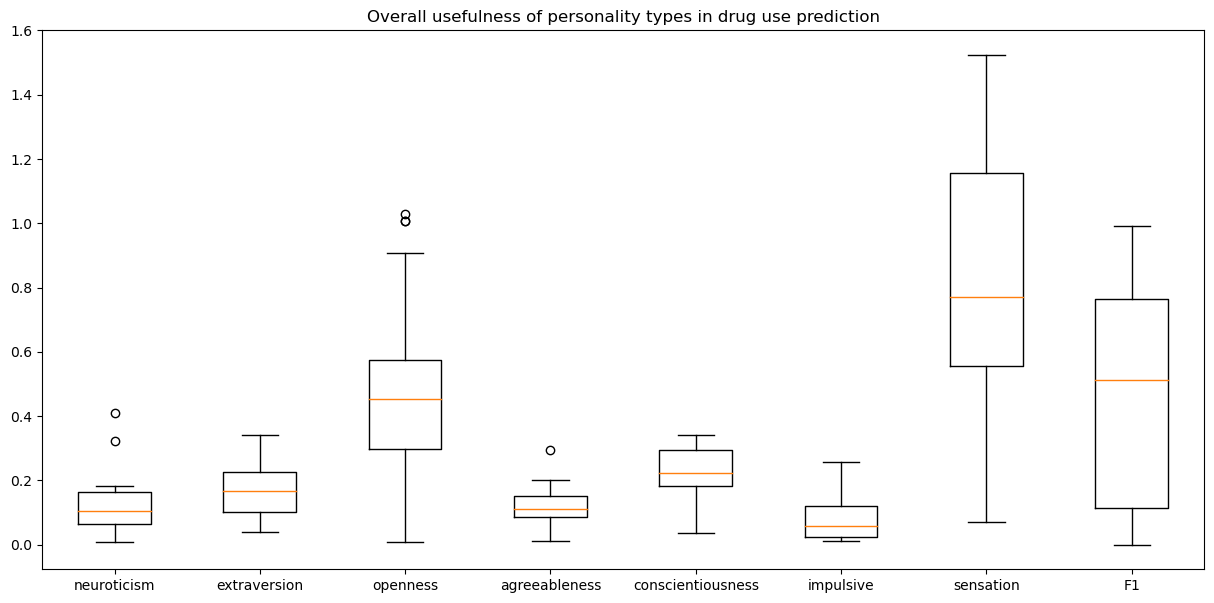

In [367]:
_, ax = plt.subplots(1,1, figsize=(15,7))

ax.boxplot(drug_df.T, labels=pers[:-1]+['F1'])
ax.set_title('Overall usefulness of personality types in drug use prediction');

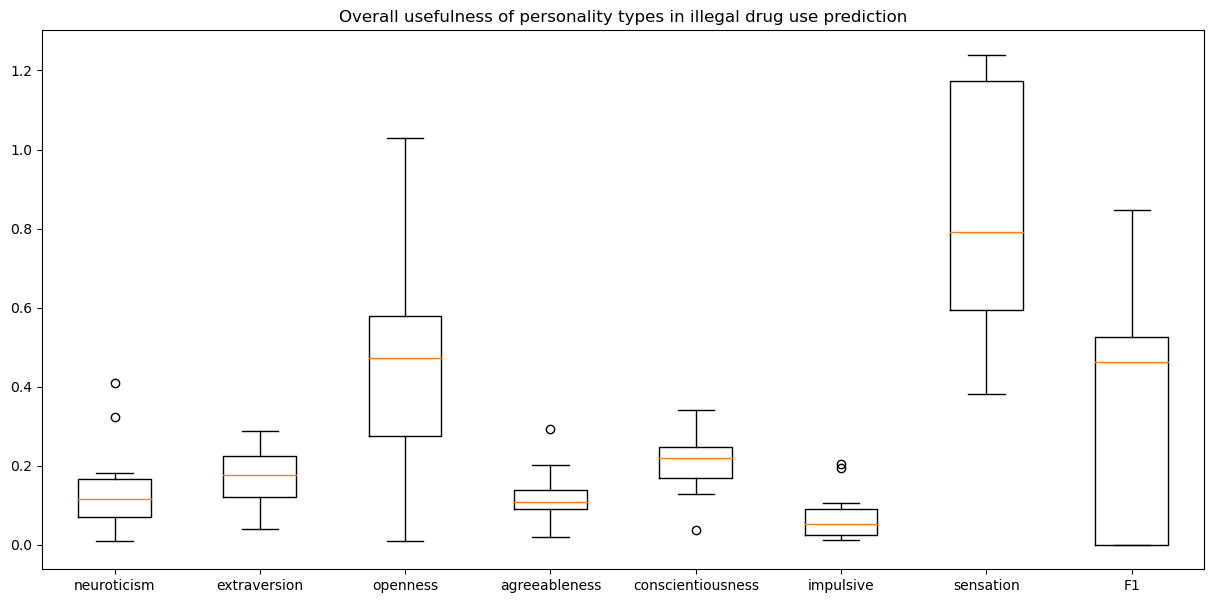

In [368]:
_, ax = plt.subplots(1,1, figsize=(15,7))

ax.boxplot(drug_df[ileg].T, labels=pers[:-1]+['F1'])
ax.set_title('Overall usefulness of personality types in illegal drug use prediction');

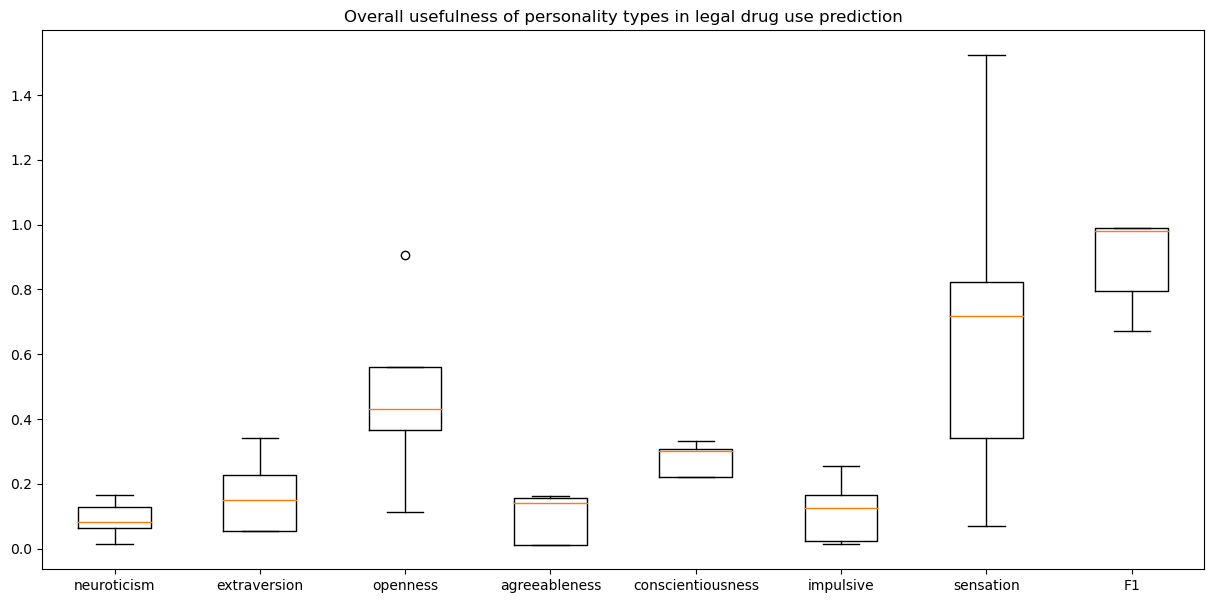

In [369]:
_, ax = plt.subplots(1,1, figsize=(15,7))

ax.boxplot(drug_df[leg].T, labels=pers[:-1]+['F1'])
ax.set_title('Overall usefulness of personality types in legal drug use prediction');

### What we've learnt:

Personality traits are useful in predicting drug use in some time scales and in some drugs

?? Do some drugs have more in common, ie similar traits useful, and if so, are they useful in the same direction?

In [370]:
ileg + leg

['Amphet',
 'Amyl',
 'Benzos',
 'Cannabis',
 'Coke',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'LSD',
 'Meth',
 'Mushrooms',
 'VSA',
 'Alcohol',
 'Caff',
 'Choc',
 'Legalh',
 'Nicotine']

In [371]:
#pvals = {}

In [425]:
drug = 'Caff'
X = df2[pers]
y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = sm.Logit(y_train, X_train).fit()

clf.summary()

Optimization terminated successfully.
         Current function value: 0.229822
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Caff   No. Observations:                 1348
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            7
Date:                Sun, 31 Dec 2023   Pseudo R-squ.:                 0.01486
Time:                        16:17:22   Log-Likelihood:                -309.80
converged:                       True   LL-Null:                       -314.47
Covariance Type:            nonrobust   LLR p-value:                    0.2287
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
neuroticism           0.1857      0.136      1.361      0.173      -0.082       0.453
extraversion          0.2295      0.141      1.626      0.104      -0.047       0.506
openness             -0.0592      0.130     -0.454      0.650      -0.315       0.196
agreeableness         0.0449      0.122      0.368      0.713      -0.194       0.284
conscientiousness    -0.0527      0.132     -0.400      0.690      -0.311       0.206
impulsive             0.1847      0.156      1.184      0.236      -0.121       0.491
sensation             0.0771      0.163      0.472      0.637      -0.243       0.397
intercept             2.7577      0.118     23.415      0.000       2.527       2.989
=====================================================================================
"""

In [426]:
probs = clf.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, probs)

f1s = 2*(precision*recall)/(precision+recall)

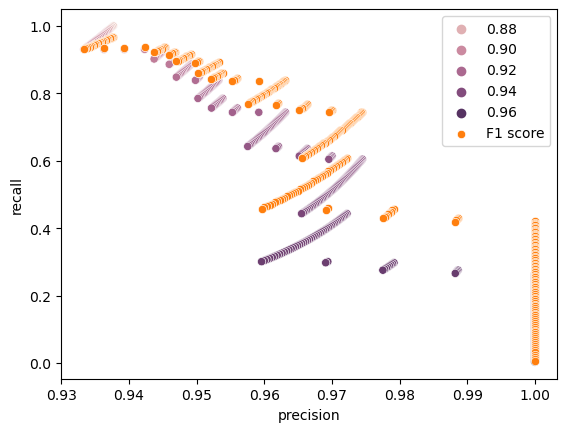

In [427]:
sns.scatterplot(x=precision[:-1], y=recall[:-1], hue=thresholds)
sns.scatterplot(y=f1s[:-1],x=precision[:-1], label='F1 score')
plt.xlabel('precision')
plt.ylabel('recall');

In [428]:
f1s = f1s[~np.isnan(f1s)] #remove invalid F1 scores where precision/recall = 0

#Prints max F1 score and its associated precision, recall and threshold
print(f'max F1:{f1s[f1s.argmax()]}\nprecision: {precision[f1s.argmax()]}\nrecall: {recall[f1s.argmax()]}\nthreshold: {thresholds[f1s.argmax()]}')


max F1:0.9678407350689127
precision: 0.9376854599406528
recall: 1.0
threshold: 0.86282541611752


Drug: Caff
F1 score: 0.956


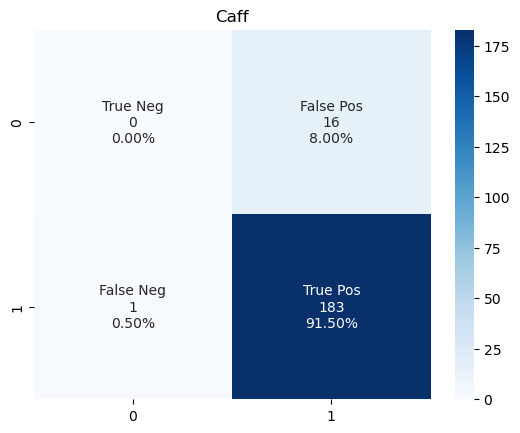

In [429]:
#now we can test against the holdout test set

X_hold = holdout[pers]
y_hold = holdout[drug]

y_pred = predictor(clf, X_hold, thresholds[f1s.argmax()])
cm = confusion_matrix(y_hold, y_pred)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_hold):.3}')
F1 = f1_score(y_pred, y_hold)
_, axes = plt.subplots(1,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
axes.set_title(f'{drug}')
axes.set_xlabel('predicted')
axes.set_ylabel('true')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes);

## Create a null model to test against


In [430]:
def rand_classifier(X, y_train):
    '''randomly assigns to a class depending on the training class probabilities'''
    p = y_train.sum()/ y_train.shape[0] # percentage positive in training set.

    y_pred = []

    for _ in X.values:
        if np.random.random() >= p:
            y_pred.append(0)
        else:
            y_pred.append(1)

    return np.array(y_pred)


In [431]:
y_pred = rand_classifier(X_hold, y_train)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_hold):.3}') # a single test isn't sufficient, but we can make multiple tests to create a confidence interval.

Drug: Caff
F1 score: 0.933


In [432]:
n = 10000
av_f1 = []
np.random.seed(42)

for _ in range(n):
    y_pred = rand_classifier(X_hold, y_train)
    av_f1.append(f1_score(y_pred, y_hold))

    
mu, std = norm.fit(av_f1)   

print(f'Mean:{sum(av_f1)/n}\nConfidence interval: {np.percentile(av_f1, 2.5):.3f}, {np.percentile(av_f1, 97.5):.3f}\nprob of getting F1 of {F1:.3}: {norm.sf(F1,mu,std):.15f}')

Mean:0.9285194370468094
Confidence interval: 0.907, 0.947
prob of getting F1 of 0.956: 0.003140483585972


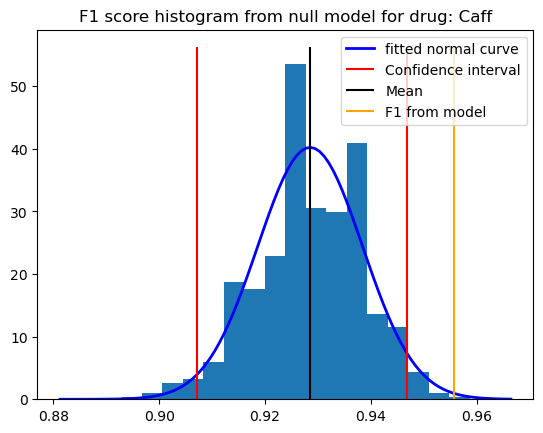

In [433]:
plt.hist(av_f1,bins=20, density=True)
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'blue', linewidth=2, label='fitted normal curve')

plt.vlines(x=[np.percentile(av_f1, 2.5),np.percentile(av_f1, 97.5)], ymin=ymin, ymax=ymax, color='r', label='Confidence interval')
plt.vlines(x=[sum(av_f1)/n], ymin=ymin, ymax=ymax, color='k', label='Mean')
plt.vlines(x=F1, ymin=ymin, ymax=ymax, color='orange', label='F1 from model')
plt.title(f'F1 score histogram from null model for drug: {drug}')
plt.legend();

In [434]:
#pvals[drug] = norm.sf(F1,mu,std)
print(f'{drug} & {F1:.3} & {norm.sf(F1,mu,std):.15f} & {np.percentile(av_f1, 2.5):.3f} & {np.percentile(av_f1, 97.5):.3f}\\\\ ')

Caff & 0.956 & 0.003140483585972 & 0.907 & 0.947\\ 


Drug     & F1    & p-val             & CI_L  & CI_U \\
any_illeg & 0.728 & 0.000000001922480 & 0.422 & 0.574\\
Amphet & 0.25 & 0.013536352960228 & 0.000 & 0.245\\
Amyl & 0.154 & 0.023394879787849 & 0.000 & 0.222\\
Benzos & 0.357 & 0.000392725595366 & 0.036 & 0.281\\
Cannabis & 0.66 & 0.000000005368284 & 0.314 & 0.491\\
Coke & 0.431 & 0.000000062958455 & 0.000 & 0.235\\
Crack & 0.0625 & 0.188830107531747 & 0.000 & 0.000\\
Ecstasy & 0.409 & 0.000002810406797 & 0.000 & 0.255\\
Heroin & 0.0 & 0.677694298260445 & 0.000 & 0.182\\ 
Ketamine & 0.353 & 0.000001408333535 & 0.000 & 0.200\\
LSD & 0.23 & 0.011668728765655 & 0.000 & 0.222\\
Meth & 0.265 & 0.003211827692847 & 0.000 & 0.229\\
Mushrooms & 0.294 & 0.000736993779239 & 0.000 & 0.227\\
VSA & 0.136 & 0.033761489019769 & 0.000 & 0.250\\
Alcohol & 0.919 & 0.000003511389585 & 0.799 & 0.871\\
Caff & 0.956 & 0.003140483585972 & 0.907 & 0.947\\
Choc & 0.974 & 0.001887778672576 & 0.930 & 0.964\\
Legalh & 0.343 & 0.000344762348582 & 0.032 & 0.259\\
Nicotine & 0.636 & 0.000017452472658 & 0.382 & 0.545\\

## Next steps: 

Put this together nicely to calc for each drug. Then calc a correction for multihypothosis testing.

In [435]:
pvals = {'any_illeg': 1.9224802076138628e-09,
 'Amphet': 0.013536352960227737,
 'Amyl': 0.023394879787849297,
 'Benzos': 0.0003927255953659883,
 'Cannabis': 5.3682836026935796e-09,
 'Coke': 6.295845544393035e-08,
 'Crack': 0.18883010753174673,
 'Ecstasy': 2.810406797480583e-06,
 'Heroin': 0.6776942982604451,
 'Ketamine': 1.408333535085112e-06,
 'LSD': 0.011668728765655464,
 'Meth': 0.003211827692846563,
 'Mushrooms': 0.0007369937792393972,
 'VSA': 0.03376148901976857,
 'Alcohol': 3.511389585459443e-06,
 'Caff': 0.003140483585971708,
 'Choc': 0.0018877786725761169,
 'Legalh': 0.0003447623485817619,
 'Nicotine': 1.7452472657766193e-05}

In [436]:
len(pvals.keys())

19

In [437]:
#Family-wise error rate = 1 – (1-α)n
alp = 0.05
n=len(pvals.keys())

1 - ((1-alp)**n) #There is a high likelihood of making a type 1 error, ie concluding there is a relationship when one doesn't really exist

0.6226463974646927

In [438]:
#Bonferroni correction

alp_new = alp/n

alp_new

0.002631578947368421

In [439]:
users = pd.DataFrame(columns=['users%'])

for i in leg+ileg+['any_illeg']:
    temp = [i,df2[i].sum(axis=0)/df2.shape[0]]
    #print(f'{i} users: {df2[i].sum(axis=0)/df2.shape[0]:.1%}')
    users.loc[i] = round(100*df2[i].sum(axis=0)/df2.shape[0], 2)

In [440]:
for k,v in pvals.items():
    if v <= alp_new:
        #print(f'{k}: significant, pval: {v}, \nPercentage users: {users.loc[k]["users%"]:.2f}%')
        print(f'{k}: significant, pval: {v}')

any_illeg: significant, pval: 1.9224802076138628e-09
Benzos: significant, pval: 0.0003927255953659883
Cannabis: significant, pval: 5.3682836026935796e-09
Coke: significant, pval: 6.295845544393035e-08
Ecstasy: significant, pval: 2.810406797480583e-06
Ketamine: significant, pval: 1.408333535085112e-06
Mushrooms: significant, pval: 0.0007369937792393972
Alcohol: significant, pval: 3.511389585459443e-06
Choc: significant, pval: 0.0018877786725761169
Legalh: significant, pval: 0.0003447623485817619
Nicotine: significant, pval: 1.7452472657766193e-05


In [441]:
for k,v in pvals.items():
    if v > alp_new:
        #print(f'{k}: Not significant, pval: {v}, \nPercentage users: {users.loc[k]["users%"]:.2f}%')
        print(f'{k}: Not significant, pval: {v}')

Amphet: Not significant, pval: 0.013536352960227737
Amyl: Not significant, pval: 0.023394879787849297
Crack: Not significant, pval: 0.18883010753174673
Heroin: Not significant, pval: 0.6776942982604451
LSD: Not significant, pval: 0.011668728765655464
Meth: Not significant, pval: 0.003211827692846563
VSA: Not significant, pval: 0.03376148901976857
Caff: Not significant, pval: 0.003140483585971708
